<a href="https://colab.research.google.com/github/ElvisRojasM/Construction-of-Socioeconomic-Indicators-Using-Python/blob/main/4_Tasa_de_pobreza_monetaria_ENAHO_Sumaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasa de pobreza monetaria- ENAHO modulo Sumaria

1. **Carga y Preprocesamiento de Datos**:
   - Descarga y lectura de archivos de datos SPSS desde fuentes INEI para diferentes módulos.
   - Renombrado y unificación de columnas para consistencia.
   - Unión de datos de diferentes módulos basándose en identificadores comunes.
   - Normalización de las variables "DOMINIO" y "ESTRATO" para asegurar uniformidad en los datos.

2. **Creación de Variables de Estudio**:
   - **Ingreso Per Cápita Mensual (gmpc)**: Calculado dividiendo el gasto del hogar por el número de miembros del hogar y el número de meses.
   - **Pobreza**: Clasificada en 'pobre' y 'no pobre' comparando el ingreso per cápita mensual con la línea de pobreza.
   - **Pobreza Extrema**: Clasificada en 'pobre extremo', 'pobre no extremo' y 'no pobre' comparando el ingreso per cápita mensual con las líneas de pobreza extrema y no extrema.

3. **Cálculo de Tasas Ponderadas de Pobreza**:
   - Uso de pesos muestrales para calcular tasas ponderadas de pobreza y pobreza extrema.
   - Agregación de resultados a nivel de región, departamento, dominio y áreas (Urbano y Rural) para proporcionar una visión geográfica detallada de estos indicadores.

4. **Elaboración de reportes y graficos**

In [ ]:

import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO

import matplotlib.pyplot as plt

import requests
from zipfile import ZipFile
from io import BytesIO

from functools import partial, reduce
import time

from google.colab import drive
from timeit import default_timer as timer


In [ ]:
pip install pyreadstat

In [ ]:
pip install geopandas

In [ ]:
def weighted_mean(df, col, by, wt, frequency=False):
    '''
    df : dataframe; col : column for which you want statistics, must be single column;    by : groupby column(s)
    wt : column to use for weights;    frequency : if True, use sample size as sum of weights (only effects degrees of freedom correction for unbiased variance)
    '''
    if isinstance(by, list):
        df = df.sort_values(by+[col])
    else:
        df = df.sort_values([by] + [col])

    newcols = ['gb_weights', 'col_weighted', 'gb_weights_cumsum', 'ngroup']
    assert all([c not in df.columns for c in newcols])

    df['gb_weights'] = df[wt]/df.groupby(by)[wt].transform('sum')

    df['gb_weights_cumsum'] = df.groupby(by)['gb_weights'].cumsum()

    df['col_weighted'] = df.eval('{}*gb_weights'.format(col))

    wmean = df.groupby(by)['col_weighted'].sum()
    wmean.name = col
    return pd.DataFrame(wmean).reset_index()

In [ ]:
def get_data_inei(zip_url,number_file,cols=None):
    r          = requests.get(zip_url)
    z          = ZipFile(BytesIO(r.content))
    zipflies   = z.namelist()
    substr     = ['.csv', '.dta', '.sav']
    data_files = []
    for i in substr:
        for j in zipflies:
            if(j.find(i)!=-1 and j not in data_files):
                data_files.append(j)
    print('=====================================================================')
    [print(f'"{a}"') for a in data_files]
    print('=====================================================================')
    file_type  = data_files[number_file].split('.')[-1] ## identifica el tipo de file: sav, csv,  dta,
    rad        = z.extract(data_files[number_file])

    print(f'file type is ".{file_type}"')
    print('=====================================================================')
    df       = pd.read_spss(rad,usecols=cols)
    print(f'successfully "{data_files[number_file]}" file read')
    print('=====================================================================')

    return df

In [ ]:
def pov_rate_cat(datos, categoria_columna, peso_poblacion,peso_tasa_pobre, categorias, year):
    total_poblacion   = datos[peso_tasa_pobre].sum()
    pov_rate_Store  = []

    for categoria in categorias:
        datos_categoria     = datos[datos[categoria_columna] == categoria]

        ## poblacion ponderada
        pobla = datos_categoria.groupby(categoria_columna)[peso_poblacion].sum().values[0]

        ## tasa de pobreza ponderada
        poblacion_categoria = datos_categoria.groupby(categoria_columna)[peso_tasa_pobre].sum().values[0]
        pobreza_ponderada   = (datos_categoria[peso_tasa_pobre] * (datos_categoria[categoria_columna] == categoria)).sum()
        tasa_ponderada      = pobreza_ponderada / total_poblacion
        pov_rate_Store.append( (categoria, pobla, tasa_ponderada) )

    df_tasas_pobreza = pd.DataFrame(pov_rate_Store, columns=['Categoría', 'Población','Tasa de pobreza ponderada'])
    df_tasas_pobreza['Población'] = df_tasas_pobreza['Población'].apply(lambda x: "{:,.0f}".format(x))  # Formato largo para la población
    df_tasas_pobreza['year'] = year
    return df_tasas_pobreza

In [ ]:
"https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/279-Modulo34.zip"

'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/279-Modulo34.zip'

In [ ]:
codigos = [280,281,282,283,284,285,279,291,324,404,440,498,546,603,634,687,737,759,784]

pov_mun_Store=[]; pov_dep_Store_map=[];pov_dep_Store_st=[];pov_dom_Store = [];
pov_area_Store = []; pov_rate_cat_Store = []; pov_ext_rate_cat_Store= [];

estr_Store = [];

year = 2004;

for ii in codigos:
  url = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(ii) + '-Modulo34.zip'
  print(' ========================================================================================================================================== ')
  print(f'year: {year} - code survey: {ii} and url: {url}\n')
  print(' ========================================================================================================================================== \n')

# , kws_list = ['sumaria'], cols = ['UBIGEO,'GASHOG2D', 'MIEPERHO', 'FACTOR07', 'DOMINIO','ESTRATO']
  if year >= 2016:
    sumaria = get_data_inei(url, 1 , cols = ['UBIGEO','GASHOG2D', 'MIEPERHO', 'FACTOR07', 'factor07', 'DOMINIO','ESTRATO', 'LINEA','linea','LINPE','linpe'])
  else:
    sumaria = get_data_inei(url, 0 , cols = ['UBIGEO','GASHOG2D', 'MIEPERHO', 'FACTOR07', 'factor07', 'DOMINIO','ESTRATO', 'LINEA','linea','LINPE','linpe'])

  sumaria.columns    = sumaria.columns.str.upper()
  sumaria['ID_DEP']  = [x[0:2]  for x in sumaria['UBIGEO'] ]

  print(f'year : {year} and variables : {list(sumaria)}')

  ##uniformizando la variable DOMINIO:
  sumaria['DOMINIO']  = sumaria['DOMINIO'].str.lower().str.normalize("NFD").str.split().str[0]
   ##creando la variable la variable area:
  sumaria['ESTRATO']  = sumaria['ESTRATO'].str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  sumaria['ESTRATO']  = sumaria['ESTRATO'].str.replace(",", " ",regex=False)\
                                          .str.replace("(", "",regex=False)\
                                          .str.replace(")", "",regex=False)\
                                          .str.replace("-", "",regex=False)\
                                          .str.replace("  ", " ",regex=False)
  if year < 2016:
    cndt = ((sumaria['ESTRATO'] =='area de empadronamiento rural aer simple') | (sumaria['ESTRATO'] == 'area de empadronamiento rural aer compuesto') | (sumaria['ESTRATO']  == 'menos de 401 viviendas'))
    sumaria['area'] = np.where(cndt, 'Rural', 'Urbano')
  else:
    cndt = ((sumaria['ESTRATO'] =='area de empadronamiento rural aer simple') | (sumaria['ESTRATO'] == 'area de empadronamiento rural aer compuesto') | (sumaria['ESTRATO']  == 'de 500 a 1 999 habitantes'))
    sumaria['area'] = np.where(cndt, 'Rural', 'Urbano')

  ## creacion de variables de pobreza
  sumaria['gmpc']    =  sumaria['GASHOG2D'] / (sumaria['MIEPERHO']*12)

  sumaria['facpob']  =  sumaria['FACTOR07']*sumaria['MIEPERHO']
  sumaria['pobre']   = ((sumaria['gmpc'] < sumaria['LINEA']))*100


  ## Pobreza:
  condiciones1 = [(sumaria['gmpc'] < sumaria['LINEA']),
                    (sumaria['gmpc'] >= sumaria['LINEA']) ]
  categorias1 = ['pobre', 'no pobre']
  sumaria['pob_cat'] = np.select(condiciones1, categorias1, default = 'otro')

  ## pobreza extrema
  condiciones2 = [
      (sumaria['gmpc'] < sumaria['LINPE']),
      ((sumaria['gmpc'] >= sumaria['LINPE']) &  (sumaria['gmpc'] < sumaria['LINEA']) ),
      (sumaria['gmpc'] > sumaria['LINEA'])
      ]
  categorias2 = ['pobre extremo', 'pobre no extremo', 'no pobre']
  sumaria['pob_ex_cat'] = np.select(condiciones2, categorias2, default = 'otro')

  ### Diferentes grupos de la poblacion:
  ### 1. Distrital:
  #pov_mun          = weighted_mean(sumaria, col='pobre', by= 'UBIGEO', wt= 'facpob', frequency=False).set_index('UBIGEO').T.reset_index(drop=True)
  #pov_mun['year']  = year
  #pov_mun_Store.append(pov_mun)

  ### 2. Por departamento para mapa
  pov_dep         = weighted_mean(sumaria, col='pobre', by= 'ID_DEP', wt='facpob', frequency=False)
  pov_dep['year'] = year
  pov_dep_Store_map.append(pov_dep)

  ## Para serie de tiempo por departamento.
  pov_dep         = weighted_mean(sumaria, col='pobre', by= 'ID_DEP', wt='facpob', frequency=False).set_index('ID_DEP').T.reset_index(drop=True)
  pov_dep['year'] = year
  pov_dep_Store_st.append(pov_dep)
  ## 3. Por dominio para serie de tiempo
  pov_dom            = weighted_mean(sumaria, col= 'pobre', by= 'DOMINIO', wt='facpob', frequency=False).set_index('DOMINIO').T.reset_index(drop=True)
  pov_dom['year']    = year
  pov_dom_Store.append(pov_dom)
  ## 4. Por area: Urbano y Rural.
  pov_area            = weighted_mean(sumaria, col= 'pobre', by= 'area', wt='facpob', frequency=False).set_index('area').T.reset_index(drop=True)
  pov_area['year']    = year
  pov_area_Store.append(pov_area)

  pov_rate_cat_Store.append(pov_rate_cat(sumaria, 'pob_cat', 'facpob', 'FACTOR07', categorias1, year))
  pov_ext_rate_cat_Store.append(pov_rate_cat(sumaria, 'pob_ex_cat', 'facpob', 'FACTOR07',  categorias2, year))


  year += 1

year: 2004 - code survey: 280 and url: https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/280-Modulo34.zip


"280-Modulo34/sumaria-2004.sav"
file type is ".sav"
successfully "280-Modulo34/sumaria-2004.sav" file read
year : 2004 and variables : ['UBIGEO', 'DOMINIO', 'ESTRATO', 'MIEPERHO', 'GASHOG2D', 'LINPE', 'LINEA', 'FACTOR07', 'ID_DEP']
year: 2005 - code survey: 281 and url: https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/281-Modulo34.zip


"281-Modulo34/sumaria-2005.sav"
file type is ".sav"
successfully "281-Modulo34/sumaria-2005.sav" file read
year : 2005 and variables : ['UBIGEO', 'DOMINIO', 'ESTRATO', 'MIEPERHO', 'GASHOG2D', 'LINPE', 'LINEA', 'FACTOR07', 'ID_DEP']
year: 2006 - code survey: 282 and url: https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/282-Modulo34.zip


"282-Modulo34/SUMARIA-2006.sav"
file type is ".sav"
successfully "282-Modulo34/SUMARIA-2006.sav" file read
year : 2006 and variables : ['UBIGEO', 'DOMINIO', 'ESTRATO', 'MIEPERHO', 'GASH

In [ ]:
df_pov_cat = pd.concat(pov_ext_rate_cat_Store)
# Reestructurar los datos para tener cada categoría como una columna
df_pov_cat['Población'] = df_pov_cat['Población'].str.replace(',','').astype(int) / 1e6

column_order = ['pobre extremo', 'pobre no extremo', 'no pobre']

df_pivot1 = df_pov_cat.pivot(index='year', columns='Categoría', values='Población')
df_pivot2 = df_pov_cat.pivot(index='year', columns='Categoría', values='Tasa de pobreza ponderada')*100

df_pivot1 = df_pivot1[column_order]
df_pivot2 = df_pivot2[column_order]

df_pivot1.index = pd.date_range(start = '2003-01', freq = 'Y', periods = len(df_pivot1))
df_pivot2.index = pd.date_range(start = '2003-01', freq = 'Y', periods = len(df_pivot2))

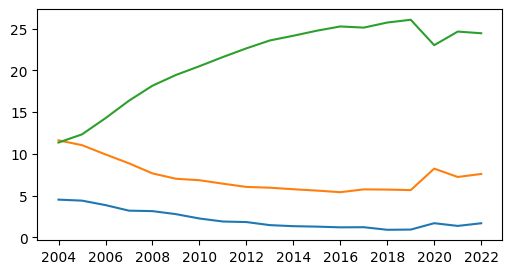

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(6,3))

for ii in df_pivot1:
  ax.plot(df_pivot1[ii] )

plt.show()

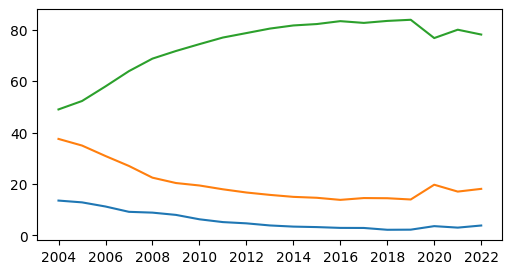

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(6,3))

for ii in df_pivot2:
  ax.plot(df_pivot2[ii] )

plt.show()

In [ ]:
import geopandas as gpd

url_dep  = "https://raw.githubusercontent.com/juaneladio/peru-geojson/master/peru_departamental_simple.geojson"
mapa_coordinates_dep = gpd.read_file(url_dep)


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

## Mapa departamental de la pobreza a lo largo del tiempo

[2004, 2014, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2013, 2005, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2022] 19
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-

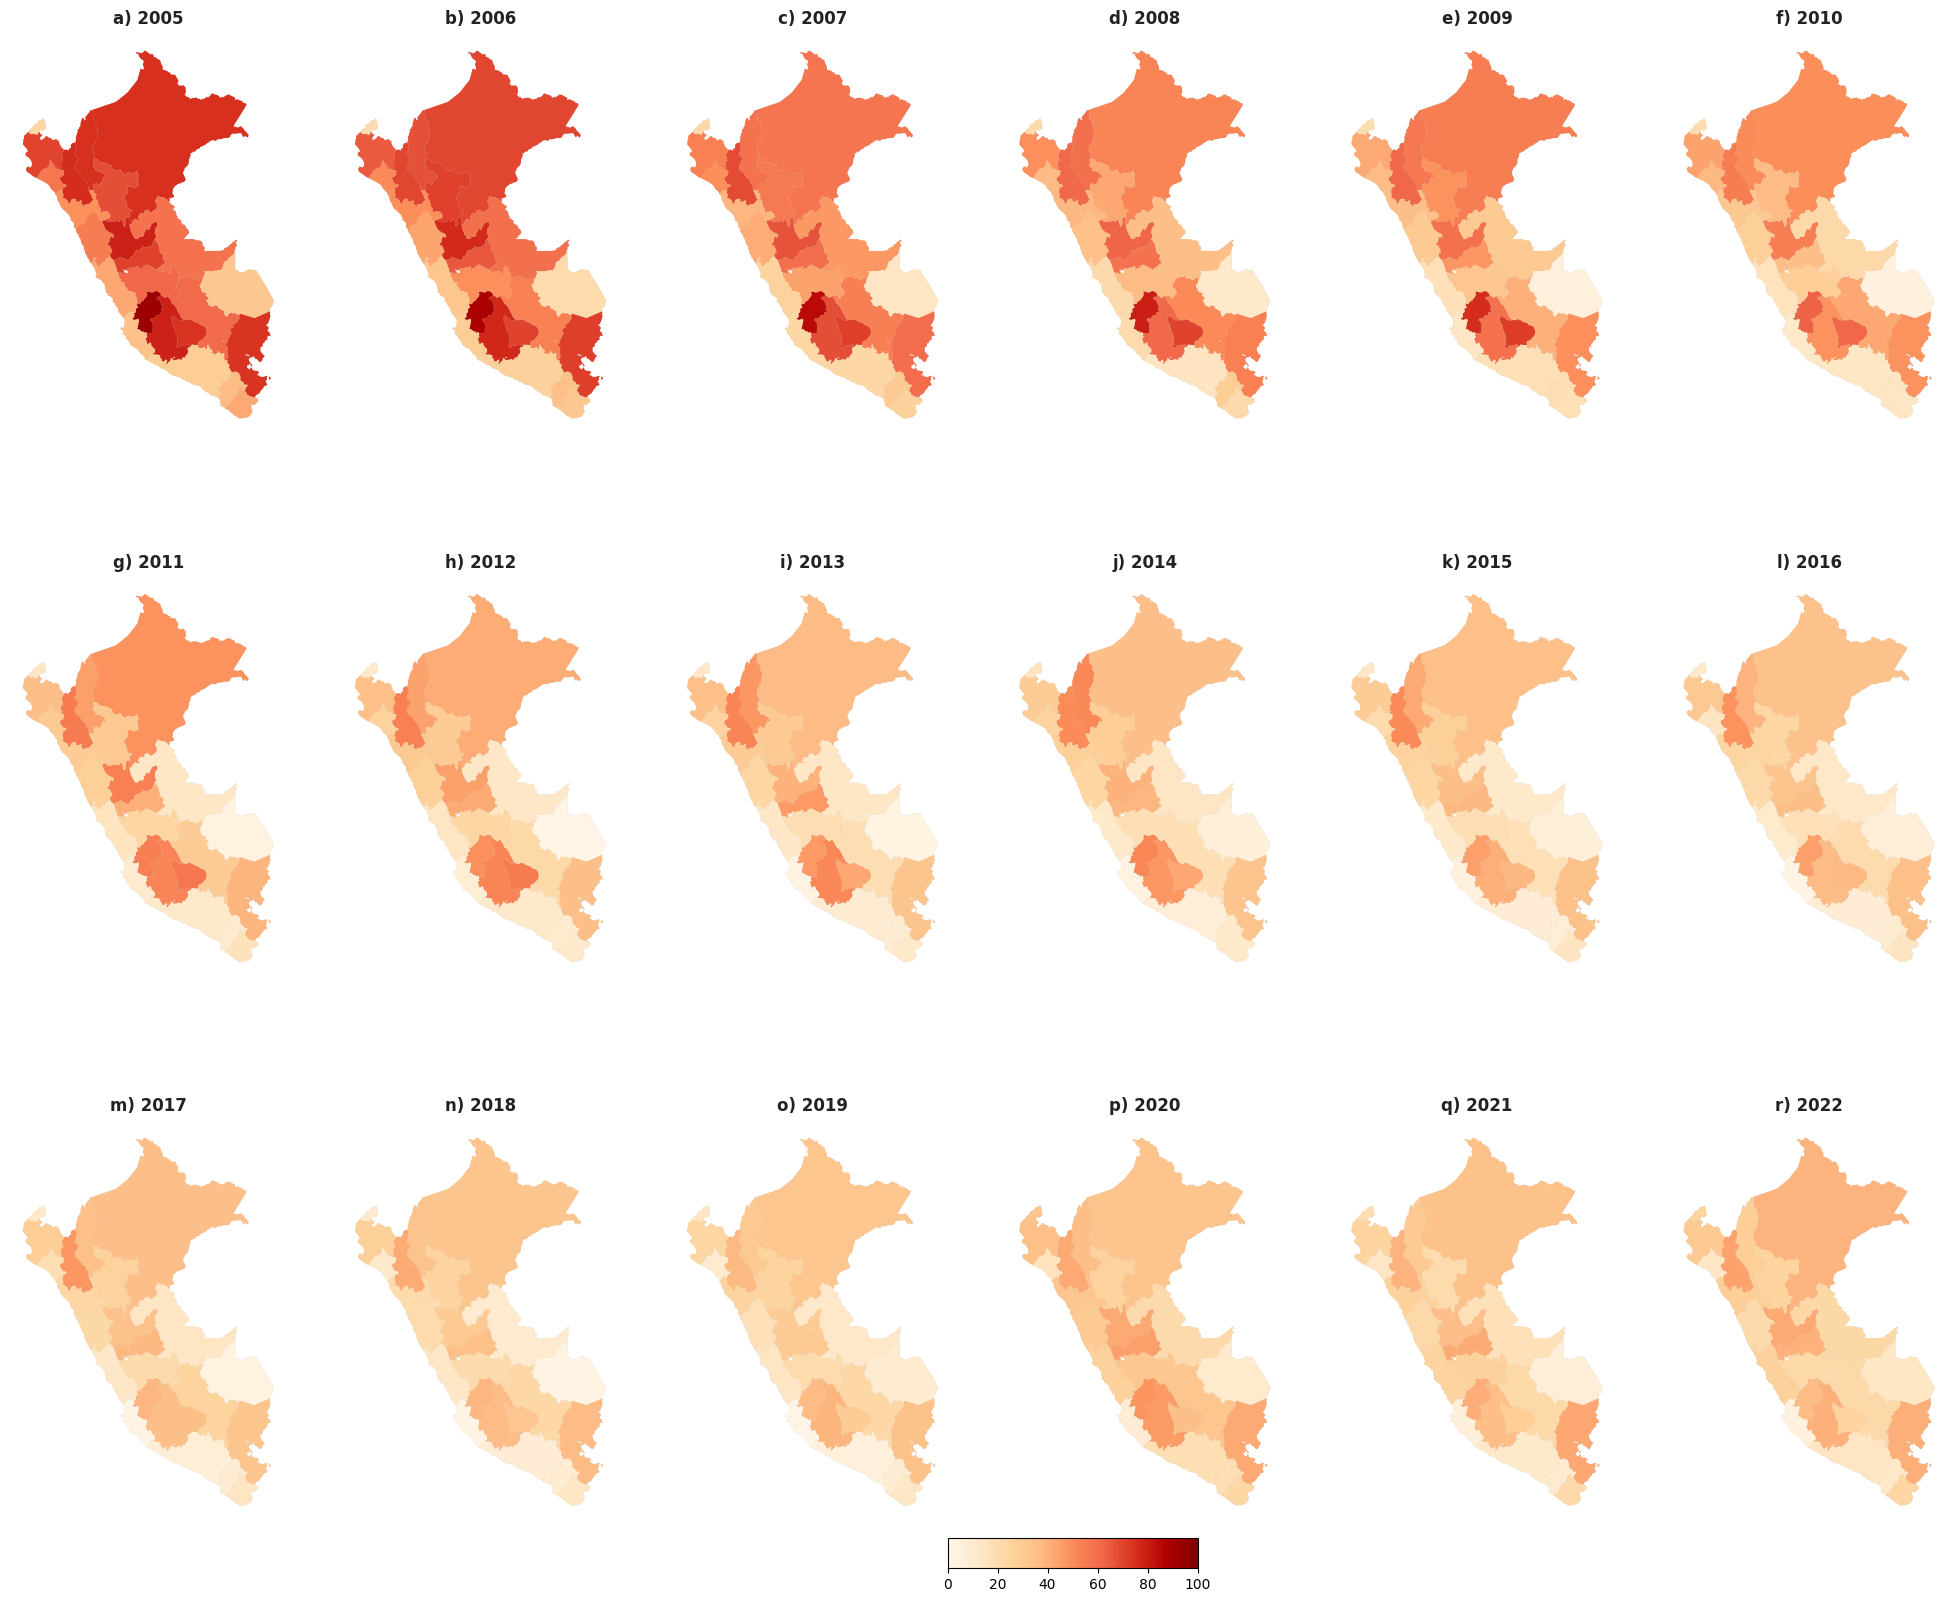

In [ ]:
### a map with 6 columns and 3 rows:
pov_dep_map = pd.concat(pov_dep_Store_map,axis=0)
### un mapa a nivel de departamentos por ano
map_dep  = pd.merge(mapa_coordinates_dep, pov_dep_map, how='inner', right_on='ID_DEP',left_on='FIRST_IDDP')

num_year = list(map_dep.year.value_counts().index)
print(num_year, len(num_year))

items = [chr(value) for value in range(97, 97+len(num_year))]
iyear = 2005; ## comenzar desde el 2005 para que la dimension de los subplots concuerden

fig, axs = plt.subplots(3, 6, figsize=(25, 20))
axs   = axs.flatten()

for ii in range(len(num_year)-1):
  print(ii,end='-')
  ax      = axs[ii]
  df_year = map_dep[map_dep.year==iyear]
  mapa_coordinates_dep.plot(ax=ax, alpha=0.35, color= "grey")
  df_year.plot(column='pobre', categorical=False, vmin=0, vmax=100, ax=ax, cmap=plt.cm.OrRd,  legend=False, legend_kwds={'orientation': 'horizontal', 'pad': 0.02}, )
  ax.axis('off')
  ax.set_title( items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')

  legend_axis = ax.figure.axes[ii]
  for label in legend_axis.get_xticklabels():
    label.set_fontproperties({'family': 'sans-serif', 'weight': 300, 'size': 8})
    label.set_color('#222222')
  iyear += 1

mappable = cm.ScalarMappable(norm=mcolors.Normalize(0,100), cmap=plt.cm.OrRd)

# define position and extent of colorbar
cb_ax = fig.add_axes([0.5, 0.1, 0.1, 0.015]) # The dimensions (left, bottom, width, height) of the new Axes
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal', pad=0.02)
#fig.savefig(path+"figures/pobreza_deps_anios.pdf", bbox_inches='tight')
#fig.savefig(path+"figures/pobreza_deps_anios.png", bbox_inches='tight')

fig.savefig("pobreza_deps_anios.pdf", bbox_inches='tight')
fig.savefig("pobreza_deps_anios.png", bbox_inches='tight')

plt.show() #Blues_r , autumn_r




#Crear el gráfico de área
fig, ax = plt.subplots(1,1,figsize=(8,5))

cmap_colors = ['#516677', '#c8572f']

for ii in df_pivot2:
  ax.plot(df_pivot2[ii],linewidth=1.5,label=ii)

plt.legend()
plt.grid()


## Poblacion en categorias de pobreza a lo largo del tiempo

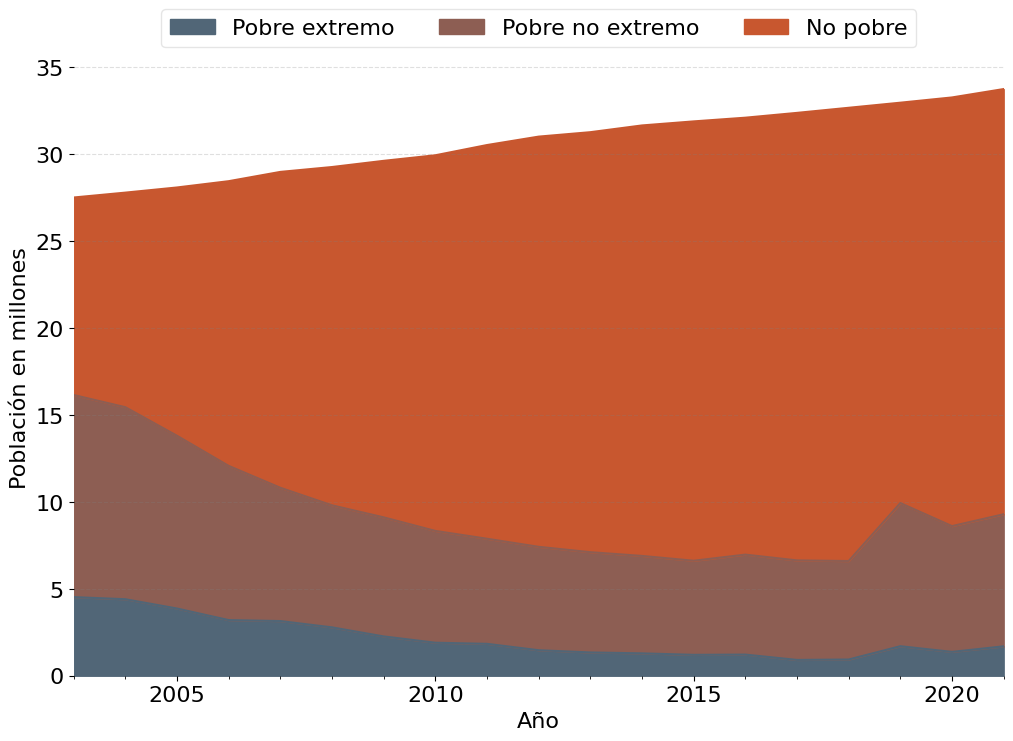

In [ ]:
import matplotlib.dates as mdates   #v 3.3.2  ###
# Crear el gráfico de área
df_pivot1 = df_pivot1.rename(columns=lambda x: x.capitalize())
# Convertir el índice a objetos de fecha
df_pivot1.index = pd.to_datetime(df_pivot1.index)

cmap_colors = ['#516677', '#c8572f']
colores = mcolors.LinearSegmentedColormap.from_list('rojo_azul', cmap_colors)


## mostrar figura
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
df_pivot1.plot(kind='area', ax=ax1, cmap=colores)

ax1.set_xlabel('Año'); ax1.set_ylabel('Población en millones');
#ax1.set_title('Población por categoría de pobreza a lo largo del tiempo')

ax1.grid(axis='y', linestyle='--',alpha=0.25,color='gray')

# Despine
for ii in ['right', 'top', 'left', 'bottom']:
  ax1.spines[ii].set_visible(False)


ftsz = 16


for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() +
             ax1.legend().get_texts()):
    item.set_fontsize(ftsz)

legend = ax1.legend( bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3, fontsize=ftsz)
legend.get_frame().set_alpha(0.5)


fig.savefig('pobreza_ext_pop_areagraph.png', bbox_inches='tight', transparent=True)



In [ ]:
## corresponde al 2022:
df_year = map_dep[map_dep.year==2022]
len(df_year)

25

In [ ]:
deps = ["Amazonas","Áncash","Apurímac","Arequipa","Ayacucho","Cajamarca","Callao",
                          "Cusco","Huancavelica","Huánuco","Ica","Junín","La Libertad","Lambayeque",
                          "Lima","Loreto","Madre de Dios","Moquegua","Pasco","Piura","Puno",
                          "San Martín","Tacna","Tumbes","Ucayali"]
print(len(deps))
df_year.loc[:, 'deps'] = deps

25


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Tasa de pobreza monetaria por departamentos para el 2022

<ipython-input-15-938fd02ffd73>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year.sort_values('pobre', ascending=True, inplace=True)


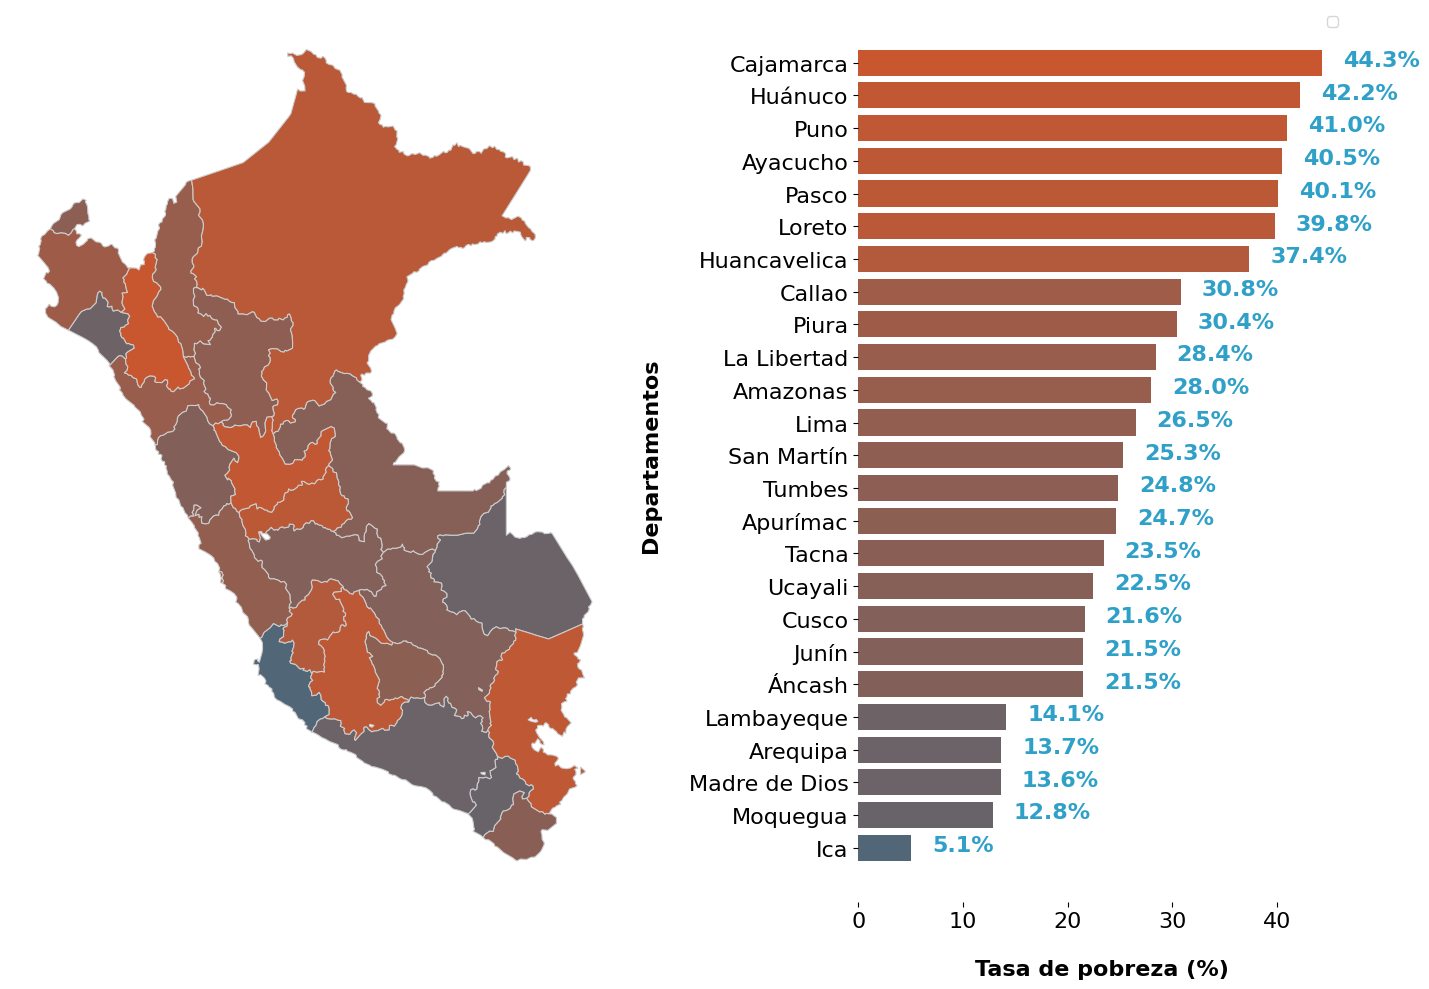

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

### Create a map with bar graph
# Crear el mapa de pobreza por departamentos

cmap_colors = ['#516677', '#c8572f']  # Rojo (1, 0, 0) a azul (0, 0, 1)
cmap = LinearSegmentedColormap.from_list('CustomMap', cmap_colors)

df_year.sort_values('pobre', ascending=True, inplace=True)

fig, (ax1,ax2 )= plt.subplots(1,2,figsize=(15, 10), gridspec_kw={'width_ratios': [1.5, 1]})

# Mapa de pobreza por departamentos
df_year.plot(column='pobre', cmap=cmap, linewidth=0.8, ax=ax1, edgecolor='0.8', legend=False)
#ax1.set_title('Mapa de Pobreza por Departamentos en Perú')
ax1.axis('off')

# Obtener los colores de los departamentos del mapa
norm = mcolors.Normalize(vmin=df_year['pobre'].min(), vmax=df_year['pobre'].max())
colores_departamentos = [cmap(norm(x)) for x in df_year['pobre']]   # Asegúrate de que 'Pobreza' coincida con el nombre de la columna en tus datos

# Graficar las barras horizontales con los colores correspondientes a cada departamento
ax2.barh(df_year['deps'], df_year['pobre'], color=colores_departamentos)  # Asegúrate de que 'Departamento' y 'Pobreza' coincidan con los nombres de las columnas en tus datos
# Despine
for ii in ['right', 'top', 'left', 'bottom']:
  ax2.spines[ii].set_visible(False)

ax2.set_xlabel("Tasa de pobreza - Año 2022", labelpad=20, weight='bold', size=14)
ax2.set_ylabel("Departamentos", labelpad = 20, weight='bold', size=14)


text_color = '#2fa0c8'#'#bf86b4'
for i, v in enumerate(df_year['pobre']):
    ax2.text(v + 2, i -0.1, str(round(v,1)) + "%", color=text_color, fontsize=ftsz, fontweight='bold' )  # #9186bf



ax2.set_xlabel('Tasa de pobreza (%)')

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels() +
             ax2.legend().get_texts()):
    item.set_fontsize(ftsz)



plt.tight_layout()
fig.savefig('pobreza_dep_map_bar_2022.png', bbox_inches='tight', transparent=True)
# Mostrar los gráficos
plt.show()



## Evolucion temporal de la tasa de pobreza monetaria por areas

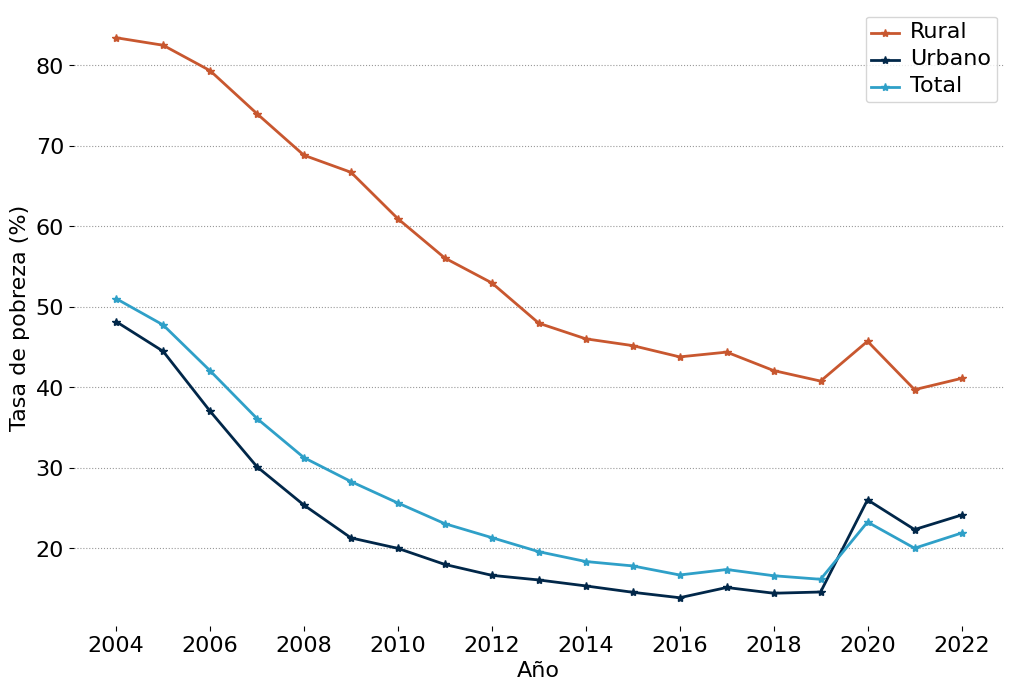

In [ ]:
pob_total = pd.concat(pov_rate_cat_Store)
pob_t = pob_total[pob_total.Categoría == 'pobre'].set_index('year', drop=True)[['Tasa de pobreza ponderada']]*100
pob_t.columns =['Total']


res_area = pd.concat(pov_area_Store,axis=0).reset_index(drop=True)
res_area.set_index("year", inplace = True)

## unir con el total
res_area = res_area.join(pob_t)

res_area.index  = pd.date_range(start = '2003-01', freq = 'Y', periods = len(res_area))
res_area.columns = res_area.columns.str.title()

colors = ['#c8572f','#012749','#2fa0c8','#ee538b']
cmap_colors = ['#516677', '#c8572f']

kk=0
fig, ax1 =plt.subplots(1,1,figsize=(12,8))
for ii in res_area:
  ax1.plot(res_area[ii], label=ii, linewidth = 2, color = colors[kk], marker='*' )


  kk+=1

ax1.grid(linestyle=':',alpha=0.8, color='gray',axis='y')
ax1.legend(ncols=3, fontsize = 14)
ax1.set_xlabel("Año", fontsize=12)


ax1.set_ylabel('Tasa de pobreza (%)')
legend = ax1.legend(loc='best')

# Ajustar la transparencia de la leyenda
legend.get_frame().set_alpha(0.5)

ftsz = 16
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() +
             ax1.legend().get_texts()):
    item.set_fontsize(ftsz)

for ii in ['right', 'top', 'left','bottom' ]:
  ax1.spines[ii].set_visible(False)



fig.savefig('pobreza_ts_area.pdf', bbox_inches='tight')
fig.savefig('pobreza_ts_area.png', bbox_inches='tight',transparent=True)

plt.show()


## Pobreza por regiones en el 2022: Grafico de barras

<ipython-input-17-b22f763c683c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pov_2022['ID_DEP'] = pov_2022['ID_DEP'].astype(int)


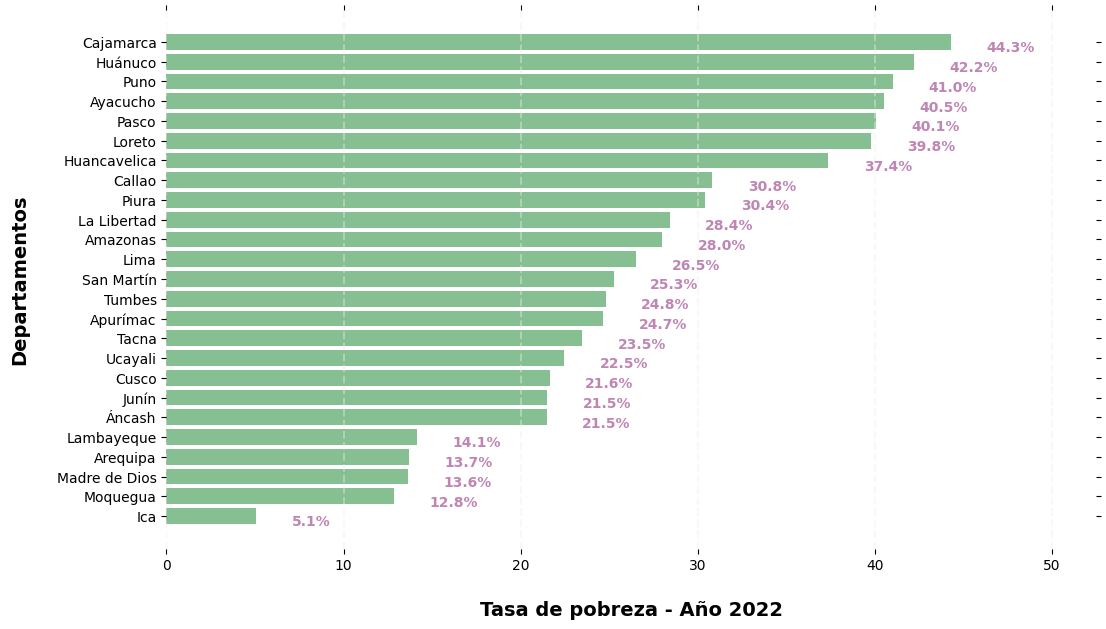

In [ ]:
dep = pd.DataFrame({ 'ID_DEP' : np.arange(1,26),
        'DEP_NAMES': ["Amazonas","Áncash","Apurímac","Arequipa","Ayacucho","Cajamarca","Callao",
             "Cusco","Huancavelica","Huánuco","Ica","Junín","La Libertad","Lambayeque",
             "Lima","Loreto","Madre de Dios","Moquegua","Pasco","Piura","Puno",
             "San Martín","Tacna","Tumbes","Ucayali"] })


pov_2022 = pov_dep_map[pov_dep_map.year==2022]

pov_2022['ID_DEP'] = pov_2022['ID_DEP'].astype(int)

pov_2022 = pd.merge(pov_2022,dep,on='ID_DEP').sort_values(by=['pobre'],ascending=True)
pov_2022 = pov_2022.set_index(['DEP_NAMES'])


from matplotlib.ticker import StrMethodFormatter

# we first need a numeric placeholder for the y axis
my_range = list(range(1,len(pov_2022.index)+1))
fig, ax = plt.subplots(1,1, figsize=(12,7))

plt.barh(my_range, pov_2022['pobre'],  color='#86bf91', align='center' )
ax.set_yticks(my_range, labels = pov_2022.index)

# Despine
for ii in ['right', 'top', 'left', 'bottom']:
  ax.spines[ii].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")  # Switch off ticks
vals = ax.get_xticks() # Draw vertical axis lines

for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Tasa de pobreza - Año 2022", labelpad=20, weight='bold', size=14)
ax.set_ylabel("Departamentos", labelpad = 20, weight='bold', size=14)

for i, v in enumerate(pov_2022['pobre']):
    ax.text(v + 2, i + 0.5, str(round(v,1)) + "%", color='#bf86b4', fontsize=10, fontweight='bold' )  # #9186bf

# Format y-axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

fig.savefig('pobreza_dep_2022.pdf', bbox_inches='tight')
fig.savefig('pobreza_dep_2022.png', bbox_inches='tight')

## EVolucion temporal de la pobreza por regiones

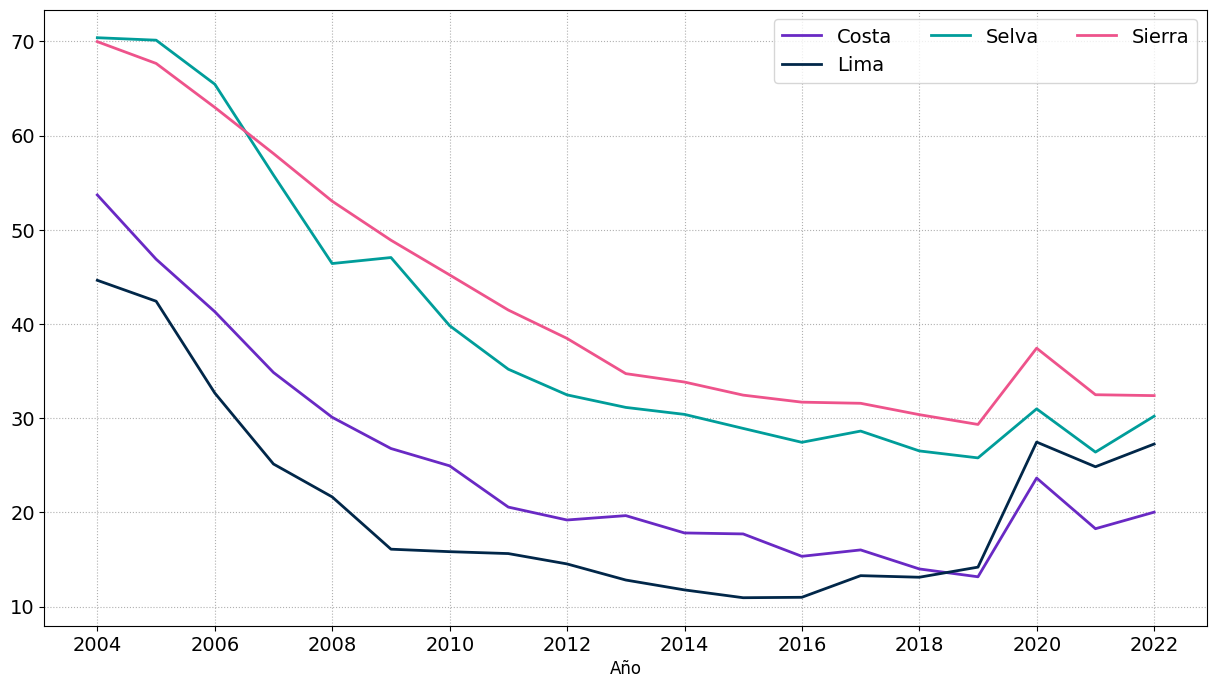

In [ ]:
res_domin = pd.concat(pov_dom_Store,axis=0).reset_index(drop=True)
res_domin.set_index("year", inplace = True)
res_domin.index  = pd.date_range(start = '2003-01', freq = 'Y', periods = len(res_domin))
res_domin.columns = res_domin.columns.str.title()

colors = ['#6929c4','#012749','#009d9a','#ee538b']

kk=0
fig, ax =plt.subplots(1,1,figsize=(15,8))
for ii in res_domin:
  ax.plot(res_domin[ii], label=ii, linewidth = 2, color = colors[kk] )
  ax.xaxis.set_tick_params(labelsize=14);   ax.yaxis.set_tick_params(labelsize=14)
  kk+=1

plt.grid(linestyle=':')
plt.legend(ncols=3, fontsize = 14)
plt.xlabel("Año", fontsize=12)

#fig.savefig(path +'figures/pobreza_ts_dom.pdf', bbox_inches='tight')
#fig.savefig(path +'figures/pobreza_ts_dom.png', bbox_inches='tight')
fig.savefig('pobreza_ts_dom.pdf', bbox_inches='tight')
fig.savefig('pobreza_ts_dom.png', bbox_inches='tight')

plt.show();